In [1]:
! pip install -q git+https://github.com/tensorflow/examples.git
! pip install -q -U tfds-nightly

In [2]:
import tensorflow as tf
import numpy as np
from tensorflow_examples.models.pix2pix import pix2pix
import tensorflow_datasets as tfds
from IPython.display import clear_output, display
import matplotlib.pyplot as plt


In [3]:
dataset, info = tfds.load('oxford_iiit_pet:4.*.*', with_info=True)

In [4]:
info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/4.0.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed and
    species. Additionally, head bounding boxes are provided for the training split,
    allowing using this dataset for simple object detection tasks. In the test
    split, the bounding boxes are empty.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_dir='C:\\Users\\vidia\\tensorflow_datasets\\oxford_iiit_pet\\4.0.0',
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=773.68 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'head_bbox': BBoxFeature(shape=(4,), dtype=float32),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'la

In [5]:
dataset

{'train': <_PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'head_bbox': TensorSpec(shape=(4,), dtype=tf.float32, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>,
 'test': <_PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'head_bbox': TensorSpec(shape=(4,), dtype=tf.float32, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>}

In [6]:
def normalize(image, mask):
  image = tf.cast(image, tf.float32)/255.
  mask -=1
  return image, mask

@tf.function
def load_image_train(data):
  print(data)
  image = tf.image.resize(data['image'], (256,256))
  mask = tf.image.resize(data['segmentation_mask'], (256,256))

  # if tf.random.uniform(()) > 0.5:
  #   image = tf.image.flip_left_right(image)
  #   mask = tf.image.flip_left_right(mask)
  
  image, mask = normalize(image, mask)
  return image, mask

def load_image_test(data):
  image = tf.image.resize(data['image'], (128,128))
  mask = tf.image.resize(data['segmentation_mask'], (128,128))

  image, mask = normalize(image, mask)
  return image, mask

In [7]:
#training and testing length
info.splits['train'].num_examples, info.splits['test'].num_examples

(3680, 3669)

In [8]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH / BATCH_SIZE

In [9]:
#The dataset already contains the required splits of test and train, so let's continue to use the same split
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

{'file_name': <tf.Tensor 'data:0' shape=() dtype=string>, 'head_bbox': <tf.Tensor 'data_1:0' shape=(4,) dtype=float32>, 'image': <tf.Tensor 'data_2:0' shape=(None, None, 3) dtype=uint8>, 'label': <tf.Tensor 'data_3:0' shape=() dtype=int64>, 'segmentation_mask': <tf.Tensor 'data_4:0' shape=(None, None, 1) dtype=uint8>, 'species': <tf.Tensor 'data_5:0' shape=() dtype=int64>}


In [10]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [11]:
def display(display_list):
  plt.figure(figsize=(5,5))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

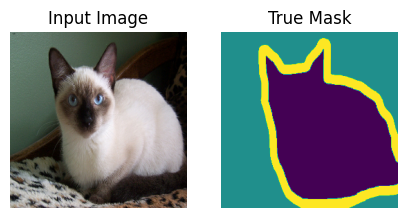

In [12]:
for image, mask in train.take(4):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

In [13]:
from data_augmentation.flip import flip_image
from data_augmentation.rotate import  rotate_image
from data_augmentation.translate import translate_images
from data_augmentation.random_crop import random_crop

1st transformation -> Flip the image 

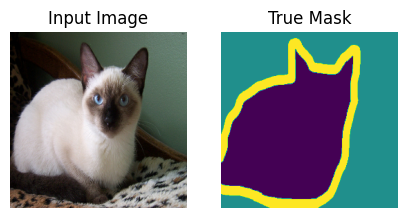

In [14]:
# Apply data augmentation (flip)
flipped_image, flipped_mask = flip_image(sample_image, sample_mask, horizontal=True, vertical=False)
# Display the flipped image and mask
display([flipped_image, flipped_mask])

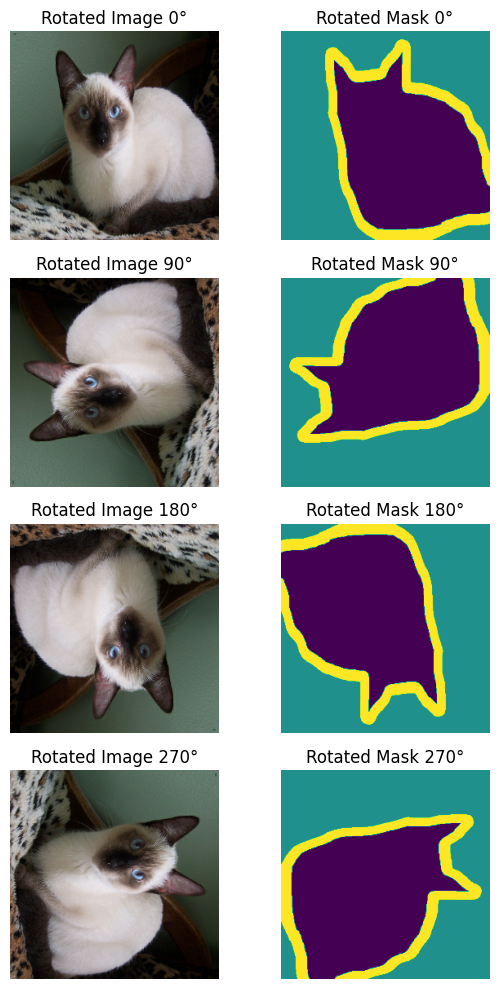

In [15]:


import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Example image and mask (replace these with your actual data)
# image = np.random.rand(256, 256, 3).astype(np.float32)  # Example image
# mask = np.random.rand(256, 256, 3).astype(np.float32)   # Example mask

# # Convert the image and mask to tensors
# image_tensor = tf.convert_to_tensor(image)
# mask_tensor = tf.convert_to_tensor(mask)

# Rotate the image and mask
rotated_images, rotated_masks = rotate_image(sample_image, sample_mask)

# Display the original and rotated images
fig, axs = plt.subplots(4, 2, figsize=(6, 10))

for i in range(4):
    axs[i, 0].imshow(rotated_images[i].numpy())
    axs[i, 0].set_title(f"Rotated Image {i*90}°")
    axs[i, 0].axis("off")

    axs[i, 1].imshow(rotated_masks[i].numpy())
    axs[i, 1].set_title(f"Rotated Mask {i*90}°")
    axs[i, 1].axis("off")

plt.tight_layout()
plt.show()

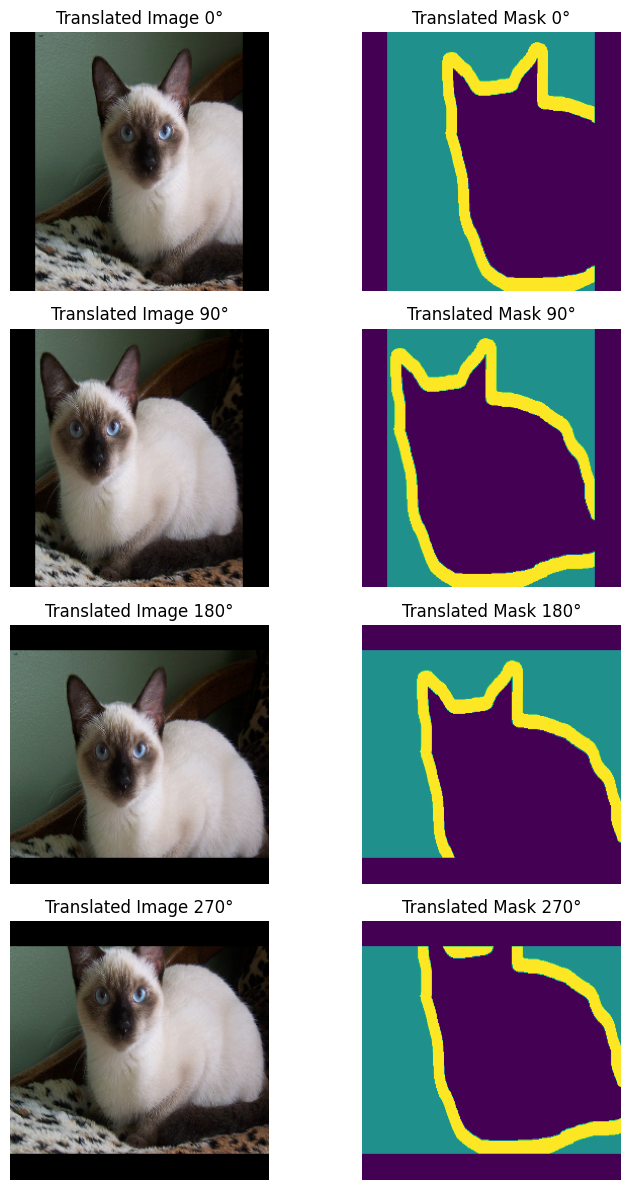

In [16]:
# Translate the image and mask
translated_images, translated_masks = translate_images(sample_image, sample_mask, IMAGE_SIZE=256)

# Plot the translated images and masks
fig, axs = plt.subplots(4, 2, figsize=(8, 12))

for i in range(4):
    axs[i, 0].imshow(translated_images[i].numpy())
    axs[i, 0].set_title(f"Translated Image {i*90}°")
    axs[i, 0].axis("off")

    axs[i, 1].imshow(translated_masks[i].numpy())
    axs[i, 1].set_title(f"Translated Mask {i*90}°")
    axs[i, 1].axis("off")

plt.tight_layout()
plt.show()

In [17]:
print(sample_image.shape)

(256, 256, 3)


(128, 128, 3)


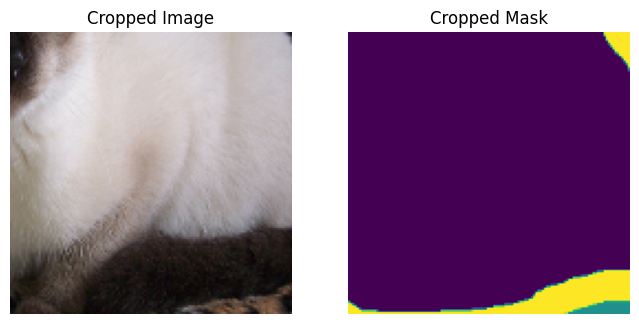

In [31]:
# Define the crop size
crop_height = 128
crop_width = 128

# Crop the image and mask
cropped_image, cropped_mask = random_crop(sample_image, sample_mask, crop_height, crop_width)
print(cropped_image.shape)
# Display the results
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(cropped_image)
plt.title('Cropped Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cropped_mask)  # Use squeeze to remove single-dimensional entries
plt.title('Cropped Mask')
plt.axis('off')

plt.show()